# Stanford CME 241 (Winter 2025) - Assignment 2

**Due: Tuesday, February 4 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 
- Eugene Francisco
- Hakeem Shindy
- Nanxi Jiang

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Question 1: Job-Hopping and Wages-Utility-Maximization (Led by Hakeem Shindy)

You are a worker who starts every day either employed or unemployed. If you start your day employed, you work on your job for the day (one of $n$ jobs, as elaborated later) and you get to earn the wage of the job for the day. However, at the end of the day, you could lose your job with probability $\alpha \in [0,1]$, in which case you start the next day unemployed. If at the end of the day, you do not lose your job (with probability $1-\alpha$), then you will start the next day with the same job (and hence, the same daily wage). 

On the other hand, if you start your day unemployed, then you will be randomly offered one of $n$ jobs with daily wages $w_1, w_2, \ldots w_n \in \mathbb{R}^+$ with respective job-offer probabilities $p_1, p_2, \ldots p_n \in [0,1]$ (with $\sum_{i=1}^n p_i = 1$). You can choose to either accept or decline the offered job. If you accept the job offer, your day progresses exactly like the **employed-day** described above (earning the day's job wage and possibly (with probability $\alpha$) losing the job at the end of the day). However, if you decline the job offer, you spend the day unemployed, receive the unemployment wage $w_0 \in \mathbb{R}^+$ for the day, and start the next day unemployed.

The problem is to identify the optimal choice of accepting or rejecting any of the job offers the worker receives, in a manner that maximizes the infinite-horizon **Expected Discounted-Sum of Wages Utility**. Assume the daily discount factor for wages (employed or unemployed) is $\gamma \in [0,1])$. Assume Wages Utility function to be $U(w) = \log(w)$ for any wage amount $w \in \mathbb{R}^+$. The goal is to maximize:

$$
\mathbb{E}\left[\sum_{u=t}^\infty \gamma^{u-t} \cdot \log(w_{i_u})\right]
$$

at the start of a given day $t$ ($w_{i_u}$ is the wage earned on day $u$, $0 \leq i_u \leq n$ for all $u \geq t$).

---

### Subquestions

#### Part (A): MDP Modeling

Express the job-hopping problem as an MDP using clear mathematical notation by defining the following components:

1. **State Space**: Define the possible states of the MDP.
2. **Action Space**: Specify the actions available to the worker at each state.
3. **Transition Function**: Describe the probabilities of transitioning between states for each action.
4. **Reward Function**: Specify the reward associated with the states and transitions.
5. **Bellman Optimality Equation**: Write the Bellman Optimality Equation customized for this MDP.

---

#### Part (B): Python Implementation

Write Python code that:

1. Solves the Bellman Optimality Equation (hence, solves for the **Optimal Value Function** and the **Optimal Policy**) with a numerical iterative algorithm. 
2. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

*Note*: For this problem, write the algorithm from scratch without using any prebuilt MDP/DP libraries or code.

---

#### Part (C): Visualization and Analysis

1. Plot the **Optimal Value Function** as a function of the state for a specific set of parameters ($n$, $w_1, \ldots, w_n$, $p_1, \ldots, p_n$, $\alpha$, $\gamma$, $w_0$).
2. Include these graphs in your submission.

---

#### Part (D): Observations

1. What patterns do you observe in the **Optimal Policy** as you vary the parameters $n$, $\alpha$, and $\gamma$?
2. Provide a brief discussion of your findings.

---

### Part (A) Answer


#### State Space:  

The state-space $\mathcal{S}$ is made up of the employment status of a worker and their current job. 
$\mathcal{S} = \{e,i | e \in [0,1], 0 \leq i \leq n\}$ where $e = 0$ corresponds to unemployment $e=1$ employment.

#### Action Space:  

If unemployed: $e = 0$ then you may choose to accept or reject the job offer. 
$\mathcal{A} = \{a, r\}$
If employed: $e = 1$ then you must do action a.

#### Transition Function:  

$P(s, a, s') =
\begin{cases} 
p_i * \alpha & \text{if } s = (0, 0), a = \text{accept job \(i\)}, s' = (1, i) \\
p_i  & \text{if } s = (0, 0), a = \text{reject job}, s' = (0, 0) \\
1 - \alpha & \text{if } s = (1, i), a = \text{accept job}, s' = (1, i) \\
0 & \text{if } s = (1, i), a = \text{reject job}, s' = (1, i') \\
0 & \text{otherwise.}
\end{cases}$

#### Reward Function:  

$R(s, a) =
\begin{cases} 
\log(w_i) & \text{if } s = (0, 0), a = \text{accept job \(i\)} \\
\log(w_0) & \text{if } s = (0, 0), a = \text{reject} \\
\log(w_i) & \text{if } s = (1, i), a = \text{accept job}.
\end{cases}$


#### Belman Optimality Equation:  

For unemployed:
$V(0, 0) = \max \Bigg\{ \sum_{i=1}^n p_i \big[\log(w_i) + \gamma V'(1, i)\big], \log(w_0) + \gamma V(0, 0) \Bigg\}.$

For employed
$V(1, i) = \log(w_i) + \gamma \Big[ (1 - \alpha) V(1, i) + \alpha V(0, 0) \Big].$


### Part (B) Answer

In [13]:
import numpy as np
    # Number of jobs
def solve_mdp(n, wages, probs, alpha, gamma, w0, tol=1e-6):
    """
    Solves the Bellman Optimality Equation for the job-hopping problem.
    
    Parameters:
    - n (int): Number of job types.
    - wages (List[float]): Daily wages for jobs [w1, ..., wn].
    - probs (List[float]): Probabilities of receiving job offers [p1, ..., pn].
    - alpha (float): Probability of losing a job at the end of the day.
    - gamma (float): Discount factor.
    - w0 (float): Unemployment wage.
    - tol (float): Convergence tolerance.
    
    Returns:
    - V (dict): Optimal value function.
    - policy (dict): Optimal policy (accept/reject thresholds for unemployment).
    """
    # Initialize Value Function
    V = {(0, 0): 0}  # Unemployed state
    for i in range(1, n + 1):
        V[(1, i)] = 0  # Employed states
    
    while True:
        V_new = {}  # Store updated values
        
        # Update employed states
        for i in range(1, n + 1):
            V_new[(1, i)] = np.log(wages[i - 1]) + gamma * ((1 - alpha) * V[(1, i)] + alpha * V[(0, 0)])
        
        # Update unemployed state
        expected_employment_value = sum(
            probs[i] * (np.log(wages[i]) + gamma * V_new[(1, i + 1)])
            for i in range(n)
        )
        unemployed_value = max(expected_employment_value, np.log(w0) + gamma * V[(0, 0)])
        V_new[(0, 0)] = unemployed_value
        
        # Convergence check
        delta = max(abs(V_new[s] - V[s]) for s in V)
        if delta < tol:
            break
        V = V_new
    
    # Compute Policy (Acceptance Threshold)
    policy = {}
    for i in range(n):
        accept_value = np.log(wages[i]) + gamma * V[(1, i + 1)]
        reject_value = np.log(w0) + gamma * V[(0, 0)]
        policy[wages[i]] = 'Accept' if accept_value > reject_value else 'Reject'
    
    return V, policy

### Part C Answer

![Alt Text](screenshot.png)

In [ ]:
# Code to generate the plot

def plot_results(V, policy, wages):
    jobs = range(1, len(wages) + 1)
    
    # Plot Value Function for Employed States
    employed_values = [V[(1, i)] for i in jobs]
    plt.figure(figsize=(10, 5))
    plt.plot(jobs, employed_values, marker='o', linestyle='-', label="V(1, i) for each job")
    plt.axhline(y=V[(0, 0)], color='r', linestyle='--', label="V(0,0) (Unemployed)")
    plt.xlabel("Job Index")
    plt.ylabel("Optimal Value Function")
    plt.legend()
    plt.title("Optimal Value Function for Job-Hopping Problem")
    plt.show()
    
    # Plot Policy Decision Boundary
    accept_wages = [w for w in wages if policy[w] == "Accept"]
    reject_wages = [w for w in wages if policy[w] == "Reject"]

    plt.figure(figsize=(10, 5))
    plt.scatter(accept_wages, [1] * len(accept_wages), color='g', label="Accepted Jobs", marker='o')
    plt.scatter(reject_wages, [1] * len(reject_wages), color='r', label="Rejected Jobs", marker='x')
    plt.axhline(y=1, color='k', linestyle='--', alpha=0.5)
    plt.xlabel("Job Wage")
    plt.yticks([])
    plt.legend()
    plt.title("Policy Decision: Accept vs. Reject Job Offers")
    plt.show()

# Example usage with computed values
wages = [10, 20, 30, 40, 50]  # Example wages
V, policy = solve_mdp(n=len(wages), wages=wages, probs=[0.2] * 5, alpha=0.1, gamma=0.9, w0=5)
plot_results(V, policy, wages)

### Part (D) Answer

Increasing $\gamma$ makes the agent value future rewards more, leading to greater selectiveness when unemployed. They're more willing to wait for higher wage jobs as that increases their future rewards more. A lower $\gamma$ would have the inverse effect.
Higher $\alpha$  reduces the value of being employed, making the agent more likely to accept jobs when unemployed. Accordingly a lower $\alpha$ makes agents more selective with jobs they take as they'll be employed for longer. 
A higher $n$ also leads to increased selectivity as there's a higher chance you can be offered a job with a higher wage than $w_0$. 

Having more jobs available (higher $n$), caring highly about the future (higher $\gamma$ ), and a lower chance of unemployment (lower $\alpha$) makes agents more selective in the jobs they take. This makes sense intuitively as well. When workers have more oppurtunities they will wait to choose the best one. Younger laborers who don't care much about the future and just want some cash will work whatever jobs they can get. And if you have a very high chance of getting laid off then you'll take whatever work you can find. Additionally, the value function $V(s)$ increases with wages for employed states but flattens for very high wages due to diminishing returns of the logarithmic reward.

## Question 2: Two-Stores Inventory Control (Led by Hakeem Shindy)

We extend the capacity-constrained inventory example implemented in [rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py) as a `FiniteMarkovDecisionProcess` (the Finite MDP model for the capacity-constrained inventory example is described in detail in Chapters 1 and 2 of the RLForFinanceBook). Here we assume that we have two different stores, each with their own separate capacities $C_1$ and $C_2$, their own separate Poisson probability distributions of demand (with means $\lambda_1$ and $\lambda_2$), their own separate holding costs $h_1$ and $h_2$, and their own separate stockout costs $p_1$ and $p_2$. At 6pm upon stores closing each evening, each store can choose to order inventory from a common supplier (as usual, ordered inventory will arrive at the store 36 hours later). We are also allowed to transfer inventory from one store to another, and any such transfer happens overnight, i.e., will arrive by 6am next morning (since the stores are fairly close to each other). Note that the orders are constrained such that following the orders on each evening, each store's inventory position (sum of on-hand inventory and on-order inventory) cannot exceed the store's capacity (this means the action space is constrained to be finite). Each order made to the supplier incurs a fixed transportation cost of $K_1$ (fixed-cost means the cost is the same no matter how many units of non-zero inventory a particular store orders). Moving any non-zero inventory between the two stores incurs a fixed transportation cost of $K_2$. 

Model this as a derived class of `FiniteMarkovDecisionProcess` much like we did for `SimpleInventoryMDPCap` in the code repo. Set up instances of this derived class for different choices of the problem parameters (capacities, costs etc.), and determine the Optimal Value Function and Optimal Policy by invoking the function `value_iteration` (or `policy_iteration`) from file [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py).

Analyze the obtained Optimal Policy and verify that it makes intuitive sense as a function of the problem parameters.

In [ ]:
# fill in with Python code
# fill in with Python code
import sys
sys.path.append('../../')
from dataclasses import dataclass
from typing import Tuple, Dict, Mapping
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.policy import FiniteDeterministicPolicy
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from rl.dynamic_programming import value_iteration_result
from rl.distribution import Categorical
from scipy.stats import poisson
from pprint import pprint

In [ ]:
@dataclass(frozen=True)
class InventoryState:
    store1_on_hand: int
    store1_on_order: int
    store2_on_hand: int
    store2_on_order: int

    def inventory_position(self) -> Tuple[int, int]:
        return (self.store1_on_hand + self.store1_on_order, 
                self.store2_on_hand + self.store2_on_order)

InvOrderMapping = Mapping[
    InventoryState,
    Mapping[Tuple[int, int, int], Categorical[Tuple[InventoryState, float]]]
]

class TwoStoreInventoryMDPCap(FiniteMarkovDecisionProcess[InventoryState, Tuple[int, int, int]]):
    def __init__(
        self,
        capacity1: int,
        capacity2: int,
        poisson_lambda1: float,
        poisson_lambda2: float,
        holding_cost1: float,
        holding_cost2: float,
        stockout_cost1: float,
        stockout_cost2: float,
        fixed_order_cost: float,
        transfer_cost: float
    ):
        self.capacity1 = capacity1
        self.capacity2 = capacity2
        self.poisson_lambda1 = poisson_lambda1
        self.poisson_lambda2 = poisson_lambda2
        self.holding_cost1 = holding_cost1
        self.holding_cost2 = holding_cost2
        self.stockout_cost1 = stockout_cost1
        self.stockout_cost2 = stockout_cost2
        self.fixed_order_cost = fixed_order_cost
        self.transfer_cost = transfer_cost

        self.poisson_distr1 = poisson(poisson_lambda1)
        self.poisson_distr2 = poisson(poisson_lambda2)
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> InvOrderMapping:
        d: Dict[InventoryState, Dict[Tuple[int, int, int], Categorical[Tuple[InventoryState, float]]]] = {}

        for s1_alpha in range(self.capacity1 + 1):
            for s1_beta in range(self.capacity1 + 1 - s1_alpha):
                for s2_alpha in range(self.capacity2 + 1):
                    for s2_beta in range(self.capacity2 + 1 - s2_alpha):
                        state = InventoryState(s1_alpha, s1_beta, s2_alpha, s2_beta)
                        ip1, ip2 = state.inventory_position()
                        base_reward = - (self.holding_cost1 * s1_alpha + self.holding_cost2 * s2_alpha)
                        action_dict: Dict[Tuple[int, int, int], Categorical[Tuple[InventoryState, float]]] = {}

                        for order1 in range(self.capacity1 - ip1 + 1):
                            for order2 in range(self.capacity2 - ip2 + 1):
                                for transfer in range(-min(s1_alpha, self.capacity2 - ip2), min(s2_alpha, self.capacity1 - ip1) + 1):
                                    new_s1_alpha = ip1 - transfer
                                    new_s2_alpha = ip2 + transfer
                                    order_cost = self.fixed_order_cost if (order1 > 0 or order2 > 0) else 0
                                    transfer_cost = self.transfer_cost if transfer != 0 else 0
                                    sr_probs_dict: Dict[Tuple[InventoryState, float], float] = {}

                                    for d1 in range(new_s1_alpha + 1):
                                        for d2 in range(new_s2_alpha + 1):
                                            prob = self.poisson_distr1.pmf(d1) * self.poisson_distr2.pmf(d2)
                                            reward = base_reward - order_cost - transfer_cost - (self.stockout_cost1 * max(0, d1 - new_s1_alpha)) - (self.stockout_cost2 * max(0, d2 - new_s2_alpha))
                                            sr_probs_dict[(InventoryState(new_s1_alpha - d1, order1, new_s2_alpha - d2, order2), reward)] = prob
                                    action_dict[(order1, order2, transfer)] = Categorical(sr_probs_dict)
                                    # Debug the actions and transitions
                                    print(f"State {state} -> Action (Order1: {order1}, Order2: {order2}, Transfer: {transfer})")
                                    print(f"  Leads to SR Probs {sr_probs_dict}")
                        d[state] = action_dict
        return d

## Question 3: Dynamic Price Optimization (Led by Eugene Francisco)

You own a supermarket, and you are $T$ days away from Halloween 🎃. You have just received $M$ Halloween masks from your supplier. You want to dynamically set the selling price of the Halloween masks at the start of each day in a manner that maximizes your **Expected Total Sales Revenue** for Halloween masks this season (assume no one will buy Halloween masks after Halloween).

Assume that for each of the $T$ days, you are required to select a price for that day from one of $N$ prices $p_1, p_2, \dots, p_N \in \mathbb{R}$, and that price is the selling price for all masks on that day. Assume that the customer demand for the number of Halloween masks on any day is governed by a Poisson probability distribution with mean $\lambda_i \in \mathbb{R}$ if you select that day’s price to be $p_i$ (where $i$ is a choice among $1, 2, \dots, N$).

Note that on any given day, the demand could exceed the number of Halloween masks you have in the store, in which case the number of masks sold on that day will be equal to the number of Halloween masks you had at the start of that day.

We spoke about this example in class - referencing the slides here (if needed) could be helpful!

---

### Subquestions

#### Part (A): Bellman Optimality Equation

Write the **Bellman Optimality Equation** customized to this Markov Decision Process (MDP). Essentially, you need to express the **Optimal Value Function** $v_*$ recursively based on taking the best action in the current state and based on the subsequent random customer demand that would produce the appropriate reward and take you to the next state.

**Note**: The probability mass function of a Poisson distribution with mean $\lambda \in \mathbb{R}$ is given by:

$$
f(k) = \frac{e^{-\lambda} \lambda^k}{k!}, \quad k = 0, 1, 2, \dots
$$

---

#### Part (B): Boundary Conditions

To be able to solve the $v_*$ recursion, you need to know the values of $v_*$ for the boundary case (boundary states). Write down the boundary case(s) for the $v_*$ recursion.

---

#### Part (C): Numerical Solution

You can solve this $v_*$ recursion (hence, solve for the **Optimal Policy** $\pi_*$) with a numerical recursive algorithm (essentially a special form of Dynamic Programming algorithm customized to this problem). 

Write Python code for this algorithm that would enable you to dynamically set the selling price at the start of each day. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

---


### Part (A) Answer

First we will setup our MDP. Our state space for each time $t$ is $\mathcal{S}_t = \{(t, I_t)\}$ for $t\in \{0,\ldots, T\}$ and where $I_t$ is an integer that is the store inventory at time $t$. Our action space is $\mathcal{A} = \{p_1,\ldots, p_N\}$. Our non-terminating states are just the $\mathcal{S}_t$. The Bellman Optimality Equation tells us that the optimal value function is one that has
\begin{align*}
	V_t^*(s) = \max_{a\in A}\sum_{s', r}\mathcal{P}(r, s'| s_t, a_t)(r + \gamma\cdot V_{t + 1}^*(s'))\tag{3.a.1}.
\end{align*}
We know that $a_t = p_k$ for some $k$. The key thing here is that, given the inventory of time $t$, we can parametrize our transition probabilities by **each of the possible next inventories $I_{t+1}$**. For a given $s = (t, I_t), s_{t + 1} = (t + 1, I_{t + 1})$, $r$ is just the revenue, meaning $r = I_t - I_{t + 1}$ (note that $I_t - I_{t + 1} \geq 0$ because we never add any masks in). All that is left is to compute $\mathcal{P}(s_t, a_t, r, s') = \mathbb{P}(s_{t + 1} = s'| s_t, a_t)$.\\

Suppose that $s_t = (t, I_t)$, $s' = (t + 1, I_{t + 1})$, and $a_t = p_\ell$. Then the customer demand was $dI_t = I_t - I_{t + 1}$.\\

**First Case:** If $I_{t + 1} > 0$, then we have
\begin{align*}
	\mathbb{P}(s_{t + 1} = s'| s_t, a_t) &=\mathbb{P}(dt = I_t - I_{t + 1}| s_t = (t, I_t), a_t = p_\ell)\\
	&= \frac{e^{-\lambda_\ell}\lambda_\ell^{dI_t}}{dI_t!}\\
	&=\frac{\exp(-\lambda_\ell)\lambda_\ell^{I_t - I_{t + 1}}}{(I_t - I_{t + 1})!}.
\end{align*}
**Second Case:** If $I_{t + 1} = 0$, then it is because $dI_t \geq I_t$, which means
\begin{align*}
	\mathbb{P}(s_{t + 1} = s'| s_t, a_t) &= \mathbb{P}(dt\geq I_t| s_t = (t, I_t), a_t = p_\ell) \\
	&= \sum_{k = I_t}^\infty \frac{\exp(-\lambda_\ell)\lambda_\ell^{k}}{k!}\\
	&=1 - \sum_{k = 0}^{I_t - 1}\frac{\exp(-\lambda_\ell)\lambda_\ell^{k}}{k!}.
\end{align*}
We can now substitute these into (3.a.1). We keep the probabilities in their general form $\mathbb{P}$ but emphasize that there are two cases for this probability depending on what $I_{t + 1}$ is. Note that the inner sum is only over each possible next inventory $I_{t + 1}$ because the revenue for a given day (our reward) is determined exactly by what $I_{t + 1}$ is.
\begin{align*}
	V_t^*(s) &= \max_{p_k\in\{p_1, \ldots, p_N\}}\sum_{I_{t + 1} = 0}^{I_t}\big[\mathbb{P}(s_{t + 1} = (t + 1, I_{t+1})| s_t = (t, I_t), a_t = p_k)\\
	&\cdot \big((I_{t} - I_{t + 1})p_k + \gamma V_t^*((t+1, I_{t + 1}))\big)\big]
\end{align*}


### Part (B) Answer

On day $T$, the revenue we can expect going forward is just what we expect to earn on day $T$ given an optimal price. Let $s_T = (t, I_T)$ and suppose that $D$ is the amount we sell (note that $D = \min(I_T, dI_T)$).
\begin{align*}
	V_T^*(s) = \max_{p_k \in \{p_1,\ldots, p_N\}}\sum_{\ell = 0}^{I_T}\mathbb{P}(D = \ell|s_T, a_T = p_k)p_kD
\end{align*}
where (note that we use the PDF $f$ and CDF $F$ in place of the actual probabilities to remove clutter; the probabilities are stated in Part A)
\begin{align*}
	\mathbb{P}(D = \ell) = \begin{cases}
		f_{\lambda_k}(\ell):&\text{if }\ell > 0\\
		1 - F_{\lambda_k}(\ell - 1):&\text{if }\ell = 0.
	\end{cases}
\end{align*}
using the same math as in Part A.

### Part (C) Answer

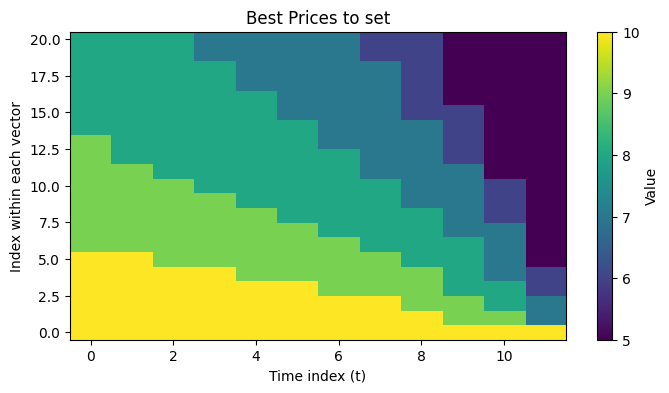

In [12]:
# fill in with Python code
import math
import matplotlib.pyplot

''' 
    Heatmap of optimal policy (prices) is at the bottom of this code. I am proud to say that (other than some debugging) this
    is all my own code (took me a while...)

    For reading this code, it is best to read from the bottom up. Lowest level functions are defined higher in the code
    (lower line numbers). Sorry about how long this is! 
'''

# The prices (made up) and their associated lambda values, organized in the form price: lambda
pricePairs: dict[float, float] = {10.0: 0.3, 9: 0.8, 8.0: 1.6, 7.0: 2.7, 6.0: 4.1, 5.0: 7.2}
possibleInventories: list[int] = [x for x in range(21)]
T = 10

def f(lmbda: float, k: int) -> float:
    '''
    Returns P(dI = k) where dI ~ Poisson(lmbda) 
    '''
    return (np.exp(-lmbda) * lmbda ** (k)) / (math.factorial(k))

def P(nextInventory: int, thisInventory: int, action: float) -> float:
    '''
    args: 
        thisInventory: the current state's inventory
        nextInventory: the next state's inventory
        action: the price set at this state
    
    returns:
        the probability of transitioning from thisInventory to nextInventory given the action's price
    '''
    D: int = thisInventory - nextInventory # the number of items that have to be sold
    parameter: float = pricePairs[action]
    
    if (D < thisInventory):
        return f(parameter, D)

    return 1 - sum([f(parameter, k) for k in range(0, D)])

def exRevBoundary(thisInventory: int, action: float) -> float:
    ''' 
    args:
        thisInventory: the inventory at time step T
        action: the price set for items at this state
    returns:
        the expected revenue given we thisInventory items and set the price at action
    '''
    return sum([P(nextInventory, thisInventory, action)*action*(thisInventory - nextInventory)
     for nextInventory in range(thisInventory + 1)])
    
def boundaryValue(state: tuple[int, int]) -> float:
    '''
    args:
        state: a tuple of (time, I_T), where I_T is the inventory at time step T
    returns:
        the value of state given we choose the price that maximizes the expected revenue on this
        last day. 
    '''
    return max([ exRevBoundary(state[1], price) 
    for price in pricePairs
    ])

def boundaryPolicy(state: tuple[int, int]) -> float:
    '''
    args:
        state: a tuple of (time, I_T), where I_T is the inventory at time step T
    returns:
        the optimal price to pick given I_T is the inventory at time step T
    '''

    # a list where each entry is a tuple of price and the associated expected revenue given we use that price
    expectedRevenues: list[tuple[float, float]] = [ (price, exRevBoundary(state[1], price)) 
    for price in pricePairs
    ]
    return max(expectedRevenues, key = lambda pricePair: pricePair[1])[0]

def calculateValueState(thisInventory: int, nextValueVector: list[int]) -> float:
    ''' 
    args:
        thisInventory: the value of I_{t}, the inventory of state s_{t}.
        nextValueVector: the optimal value function for time t + 1, v_{t+1}*
    returns:
        a float, the value of this state given that we choose a revenue maximizing action at this point.
    '''
    return max([
        sum([
            P(nextInventory, thisInventory, price)*((thisInventory - nextInventory)*price + nextValueVector[nextInventory])
        for nextInventory in range(thisInventory + 1)])
    for price in pricePairs])

def calculatePolicyState(thisInventory: int, nextValueVector: list[int]) -> float:
    ''' 
    args:
        thisInventory: the value of I_{t}, the inventory at the current state s_t.
        nextValueVector: the optimal value function for time t + 1, v_{t+1}*
    returns:
        a float, the optimal price to apply given that the current inventory is thisInventory
    '''

    # a list of each tuples where the first field is the action (price) and the second is the value of that action
    # given thisInventory.
    actionValues: list[tuple[float, float]] = [
        (   price, 
            sum([
            P(nextInventory, thisInventory, price)*((thisInventory - nextInventory)*price + nextValueVector[nextInventory])
        for nextInventory in range(thisInventory + 1)]))
    for price in pricePairs]
    return max(actionValues, key = lambda actionPair: actionPair[1])[0]

def calculateValueVector(nextValueVector: list[float]) -> list[float]:
    ''' 
    args:
        nextValueVector: the value function V^* for time step t + 1, where the jth element of
        nextValueVector represents the value of s_{t + 1} when I_{t + 1} = j
    returns:
        a vector thisValueVector representing the value function V^* for time t, where the jth component of
        thisValueVector is the value of s_{t} when I_{t} = j.
    
    *Note that calculateValue works with backward induction, so it takes in the vector of time t + 1
    and returns the vector for time t.
    '''
    return [
        calculateValueState(thisInventory, nextValueVector)
    for thisInventory in possibleInventories]

def calculatePolicyVector(nextValueVector: list[float]) -> list[float]:
    ''' 
    args:  
        nextValueVector: the value function V^* for time step t + 1, where the jth element of
        nextValueVector represents the value of s_{t + 1} when I_{t + 1} = j
    returns:
        a vector thisPolicyVector of the best prices to set. Specifically, the jth component of thisPolicyVector
        is the optimal price to set when I_t = j
    '''
    return [
        calculatePolicyState(thisInventory, nextValueVector)
    for thisInventory in possibleInventories]

def calculateAllValues(T) -> tuple[ list[list[float], list[list[float]]] ]:
    ''' 
    args: 
        T, the number of time steps in the finite MDP
    returns:
        a tuple of two lists. The first list is the value list, where each entry in the list is a vector
        of values for time step t; the value vector is indexed by the inventory at that time.
        
        The second list is a policy list, where each entry in the list is a vector of
        optimal prices to take for time step t; the policy vector is indexed by the inventory at that time.
    '''
    valueVectors: list[list[float]] = []
    policyVectors: list[list[float]] = []
    boundaryInventoryVector: list[tuple[int, int]] = [(T, inventory) for inventory in possibleInventories]

    boundaryValueVector: list[float] = [boundaryValue(state) for state in boundaryInventoryVector]
    boundaryPolicyVector: list[float] = [boundaryPolicy(state) for state in boundaryInventoryVector]

    valueVectors.insert(0, boundaryValueVector)
    policyVectors.insert(0, boundaryPolicyVector)
    t: int = T

    nextValueVector: list[float] = boundaryValueVector
    while t >= 0:
        thisValueVector = calculateValueVector(nextValueVector)
        thisPolicyVector = calculatePolicyVector(nextValueVector)
        valueVectors.insert(0, thisValueVector)
        policyVectors.insert(0, thisPolicyVector)
        
        nextValueVector = thisValueVector
        t -= 1
    
    return (valueVectors, policyVectors)

allValues, allPolicies = calculateAllValues(T)
# for values in allValues:
#     print(values)
#     print("\n")

# GPT generated plotting code:
data = np.array(allPolicies).T
plt.figure(figsize=(8, 4))
# Make a heatmap; aspect='auto' makes it easier to see if T >> N or vice versa.
plt.imshow(data, aspect='auto', cmap='viridis', origin='lower')

plt.colorbar(label='Value')

# Label the axes: 
# - The x-axis corresponds to the time index (0..T)
# - The y-axis corresponds to the positions in each vector (0..N-1)
plt.xlabel("Time index (t)")
plt.ylabel("Index within each vector")

plt.title("Best Prices to set")
plt.show()

## Question 4: Risk-Aversion and Utility Optimization under CARA Utility (Led by Eugene Francisco)

You are tasked with analyzing the behavior of an investor who seeks to maximize their utility under **CARA Utility**. The investor has wealth $W$ and the CARA utility function:

$$
U(W) = \frac{1 - e^{-aW}}{a}, \quad a > 0,
$$

where $a$ represents the investor's **risk aversion**.

The investor allocates their wealth between:
1. A **riskless asset** with a fixed return $r$, and
2. A **risky asset** with return $R \sim \mathcal{N}(\mu, \sigma^2)$

The investor allocates a fraction $\pi$ of their wealth to the risky asset and $(1 - \pi)$ to the riskless asset. The wealth $W$ after one year is given by:

$$
W = (1 + r)(1 - \pi) + (1 + R)\pi.
$$

The goal is to analyze the investor’s optimal allocation $\pi$ to the risky asset and compute key risk-related quantities.

---

### Subquestions

#### Part (A): Expected Utility and Certainty-Equivalent Wealth

1. Derive the expression for the **expected utility** $\mathbb{E}[U(W)]$, using the given CARA utility function and assuming $R \sim \mathcal{N}(\mu, \sigma^2)$.
2. Using a Taylor expansion, approximate the **certainty-equivalent wealth** $W_{CE}$ up to second-order terms.

---

#### Part (B): Optimal Portfolio Allocation

Derive the optimal fraction $\pi^*$ of wealth to be allocated to the risky asset such that the **expected utility** $\mathbb{E}[U(W)]$ is maximized. Express $\pi^*$ in terms of $a$, $\mu$, $r$, and $\sigma^2$.

---

#### Part (C): Risk Premium

1. Using the results from Part (A), calculate the **absolute risk premium** $\pi_A = \mathbb{E}[W] - W_{CE}$.
2. Verify that $\pi_A \approx \frac{a \pi^2 \sigma^2}{2}$ for small $\sigma^2$.

---

#### Part (D): Numerical Calculations and Interpretation

Given the parameters $r = 0.02$, $\mu = 0.08$, $\sigma^2 = 0.04$, and $a = 3$:
1. Compute the optimal allocation $\pi^*$.
2. Calculate the certainty-equivalent wealth $W_{CE}$.
3. Compute the absolute risk premium $\pi_A$.
4. Interpret the results and discuss how changes in $a$ and $\sigma^2$ affect the risk premium and portfolio allocation.

---

#### Part (E): Expected Utility under Uniform Distribution

Now assume that the return of the risky asset, $R$, is no longer normally distributed. Instead, $R \sim \text{Uniform}[\alpha, \beta]$, where $\alpha$ and $\beta$ are the lower and upper bounds of the distribution, respectively.

1. Derive the new expression for the **expected utility** $\mathbb{E}[U(W)]$. Make sure to simplify your result as much as possible, and ensure that it explicitly depends on $a$, $\pi$, $\alpha$, $\beta$, and $r$.

**Hint**: Use the fact that if $W \sim \text{Uniform}[w_{\text{min}}, w_{\text{max}}]$, then:

$$
\mathbb{E}[g(W)] = \frac{1}{w_{\text{max}} - w_{\text{min}}} \int_{w_{\text{min}}}^{w_{\text{max}}} g(W) \, dW.
$$

---

### Part (A) Answer

Expanding out our wealth, we have that
\begin{align*}
	W &= (1 + r)(1 - \pi) + (1 + R)\pi\\
	&=1 + r - \pi r + \pi R.
\end{align*}
Since $R\sim\mathcal{N}(\mu, \sigma^2)$, we know that $\pi R\sim\mathcal{N}(\pi \mu, \pi^2\sigma^2)$, which means (because the left hand sum of $W$ is just a scalar) that
\begin{align*}
	W &\sim \mathcal{N}(1 + r - \pi r + \pi\mu, \pi^2\sigma^2)\\
	&\sim \mathcal{N}(1 + r + \pi(\mu - r), \pi^2\sigma^2).\tag{4.a.1}
\end{align*}
We will use the fact that $W$ is distributed normally in a second. For now, notice that
\begin{align*}
	\mathbb{E}(U(x)) &= \mathbb{E}(\frac{1 - e^{-aW}}{a})\\
	&= \frac{1}{a} - \frac{1}{a}(\mathbb{E}(e^{-aW})).\tag{4.a.2}
\end{align*}
Notice that $W$ is normally distributed and that $\mathbb{E}(e^{-aW})$ is precisely the definition of the MGF of a random variable evaluated at $-a$. If $X\sim \mathcal{N}(\mu', \sigma'^2)$, recall that the MGF is
\begin{align*}
	f(a) = e^{\mu' a + \frac{\sigma'^2a^2}{2}}. 
\end{align*}
Substituting in the appropriate mean and variance from (4.a.1), we have
\begin{align*}
	\mathbb{E}(e^{aW}) = \exp[a(1 + r + \pi(\mu - r)) + \frac{\pi^2\sigma^2a^2}{2}].
\end{align*}
Using this in $(4.a.2)$, we get
\begin{align*}
	\mathbb{E}(U(W)) = \frac{1}{a} - \frac{\exp[-a(1 + r + \pi(\mu - r)) + \frac{\pi^2\sigma^2a^2}{2}]}{a}.\tag{4.a.3}
\end{align*}
We're now ready to solve for  $W_{CE}$. Recall the definition of $W_{CE}$ as
\begin{align*}
	U(W_{CE}) = \mathbb{E}(U(W)).
\end{align*}
Using (4.a.3), we have
\begin{align*}
	\implies & &\frac{1}{a} - \frac{\exp(-aW_{CE})}{a} &= \frac{1}{a} - \frac{\exp[-a(1 + r + \pi(\mu - r)) + \frac{\pi^2\sigma^2a^2}{2}]}{a} & &\\
	\implies & & \exp(-aW_{CE})) &= \exp[-a(1 + r + \pi(\mu - r)) + \frac{\pi^2\sigma^2a^2}{2}]\\
	\implies & & W_{CE} &= (1 + r + \pi(\mu - r)) - \frac{\pi^2\sigma^2a}{2}.\tag{4.a.4}
\end{align*}

### Part (B) Answer

Recall from part A (4.a.3) that
\begin{align*}
	\mathbb{E}(U(W)) = \frac{1}{a} - \frac{\exp(-a(1 + r + \pi(\mu - r)) + \frac{\pi^2\sigma^2a^2}{2})}{a}.
\end{align*}
Note that by 4.a.1, $\mathbb{E}(W) = 1 + r + \pi(\mu - r)$ and $\text{var}(W) = \pi^2\sigma^2$. Taking the derivative with respect to $\pi$ and setting that equal to 0, we have
\begin{align*}
	& & 0 &=\frac{d}{d\pi}\left[\frac{1}{a} - \frac{\exp(-a(1 + r + \pi(\mu - r)) + \frac{\pi^2\sigma^2a^2}{2})}{a}\right] & &\\
	\implies & & 0 &= -\frac{1}{a}\cdot\frac{d}{d\pi}\exp(-a(1 + r + \pi(\mu - r)) + \frac{\pi^2\sigma^2a^2}{2})\\
	\implies & & 0 &=-\frac{1}{a}\exp\left(-a\mathbb{E}(W) + \frac{\text{var}(W)a^2}{2}\right)\frac{d}{d\pi}\left(-a(1 + r + \pi(\mu - r)) + \frac{\pi^2\sigma^2a^2}{2}\right)\\
	\implies & & 0 &= \exp\left(-a\mathbb{E}(W) + \frac{\text{var}(W)a^2}{2}\right)\left[(\mu - r) - \pi\sigma^2a \right].
\end{align*}
Noting in the last line that $\exp$ is positive definite, we have
\begin{align*}
	& & 0 &= \left[(\mu - r) - \pi\sigma^2a \right] & &\\
	\implies & & \pi &= \frac{\mu - r}{\sigma^2a}. & &
\end{align*}
So our optimal investment fraction is 
\begin{equation*}
	\displaystyle\pi^* = \frac{\mu - r}{\sigma^2a}.\tag{4.b.1}
\end{equation*}


### Part (C) Answer

Recall the definition of absolute risk premium, we have
\begin{align*}
	W_{CE} = \mathbb{E}(W) - \pi_A.
\end{align*}
Matching up terms with (4.a.4), and recalling that $\mathbb{E}(W) = 1 + r + \pi(\mu - r)$ from the distribution of $W$ in part A, we see that
\begin{align*}
	\pi_A = \frac{\pi^2\sigma^2a}{2}.
\end{align*}

### Part (D) Answer


We have that $r = 0.02$, $\mu = 0.08$, $\sigma^2 = 0.04$, and $a = 3$. Using (4.b.1),
\begin{align*}
	\pi^* &= \frac{0.08 - 0.02}{0.04\cdot 3}\\
	&= 0.5.
\end{align*}
Using (4.a.4), and assuming we are using an optimal allocation strategy, we have
\begin{align*}
	W_{CE} &= (1 + 0.02 + 0.5(0.08 - 0.02)) - \frac{0.5^2\cdot 0.04 \cdot 3}{2}\\
	&= \underbrace{1.05}_{\mathbb{E}(W)} - \underbrace{0.0075}_{\pi_A}\\
	&= 1.0425
\end{align*}
Using Part C and realizing that the risk premium is just the second sum of our calculation for $W_{CE}$, we have
\begin{align*}
	\pi_A = 0.0075.
\end{align*}
\textbf{Interpretation:} The proportion of my portfolio that I should allocate to the risky asset to maximize my expected utility of wealth $\mathbb{E}(U(W))$ is precisely half of my portfolio.\\

 Since $U(W_{CE}) = \mathbb{E}(U(W))$, $W_{CE}$ is precisely how much money you'd have to give me so that the amount I value $W_{CE}$ is the same as the expected utility from the investments. In other words, paying me $1.0425$ dollars right now gives me the same value as investing my money.\\
 
In practice the expected value of my investment $\mathbb{E}(W)$ is different from our certainty equivalent wealth $W_{CE}$. The latter being the amount of money you'd have to give me so that I have no preference between receiving $W_{CE}$ and pursuing the risky investment. Instead, $W_{CE}$ is slightly lower because I'm ok with receiving a little less money if my return is certain.\\

The difference between $\mathbb{E}(W)$ and $W_{CE}$ is $\pi_A$, is the risk premium. In this case, \$0.0075 is how much I am willing to pay on top of $\mathbb{E}(W)$ such that pursuing the risky investment with $\pi^*$ is as enticing as $W_{CE}$ riskless.\\

Finally, notice that the risk premium is proportional to changes in our risk tolerance $a$ and the variance $\sigma^2$ while the allocation percentage is inversely proportional to $a$ and $\sigma^2$. This makes sense since we expect our risk premium to go up when the the investment is riskier (more variance) or when we are less tolerant of risk; and we expect that the amount we invest in the risky asset goes down when our risk tolerance goes down ($a$ goes up) or the riskiness of the investment goes up (variance). 

### Part (E) Answer

Using the hint, we know that
\begin{align*}
	\mathbb{E}(U(W)) &= \frac{1}{\beta - \alpha}\int_{\alpha}^{\beta}U(W)dW.\tag{4.e.1}
\end{align*}
First we'll just solve for the inner integral.
\begin{align*}
	\int_{x_1}^{x_2}U(x)dx &= \int_{x_1}^{x_2}\left(\frac{1 - e^{-ax}}{a}\right)dx\\
	&=\left.\frac{x}{a} + \frac{e^{-ax}}{a^2}\right|_{x_1}^{x_2}.\tag{4.e.2}
\end{align*}
Using (4.e.2) in (4.e.1), and substituting for $x_1$ and $x_2$, 
\begin{align*}
	\mathbb{E}(U(W)) &= \frac{1}{\beta - \alpha}\left(\left.\frac{x}{a} + \frac{e^{-ax}}{a^2}\right|_{\alpha}^{\beta}\right)\\
	&=\frac{1}{\beta - w_{\alpha}}\left(\frac{\beta}{a} - \frac{\alpha}{a} + \frac{\exp(-a\beta)}{a^2} - \frac{\exp(-a\alpha)}{a^2}\right)\\
	&=\frac{1}{\beta - w_{\alpha}}\left(\frac{\beta - \alpha}{a} + \frac{\exp(-a\beta) - \exp(-a\alpha)}{a^2}\right)\\
	&= \frac{1}{a} + \frac{\exp(-a\beta) - \exp(-a\alpha)}{a^2(\beta - \alpha)}
\end{align*}

## Question 5: Feeding Animals in a Zoo using Approximate Dynamic Programming (Led by Nanxi Jiang)

You are tasked with developing a feeding strategy for a zoo using **Approximate Dynamic Programming (ADP)**. The zoo has a finite amount of food available each day, and you must distribute this food among a group of animals to maximize their overall satisfaction over a fixed time horizon $T$. 

Each animal has:
1. A **hunger level** $h_i(t) \in \mathbb{R}$ at time $t$, which increases as time passes without food and decreases when food is provided.
2. A **satisfaction function** $u_i(f) = \log(1 + f)$, where $f$ is the amount of food given to the animal. Satisfaction increases logarithmically with food.

You start each day with a total amount of food $F$ that you can distribute to the animals. The objective is to maximize the **cumulative satisfaction** of all animals over $T$ days while considering that food is finite and hunger levels evolve dynamically.

---

### Problem Dynamics:
1. **State**:
   - The state at time $t$ is the vector of hunger levels of all animals: $\mathbf{h}(t) = [h_1(t), h_2(t), \dots, h_N(t)]$, where $N$ is the number of animals.

2. **Action**:
   - The action $\mathbf{f}(t) = [f_1(t), f_2(t), \dots, f_N(t)]$ represents the food allocated to each animal, subject to the constraint:
     $$
     \sum_{i=1}^N f_i(t) \leq F.
     $$

3. **State Transition**:
   - Hunger levels evolve according to the dynamics:
     $$
     h_i(t+1) = \max(0, h_i(t) + \gamma - \delta f_i(t)),
     $$
     where $\gamma$ is the natural rate at which an animal's hunger increases, and $\delta$ is the rate at which feeding reduces hunger.

4. **Reward**:
   - The reward at each time step is the total satisfaction of all animals:
     $$
     r(\mathbf{h}(t), \mathbf{f}(t)) = \sum_{i=1}^N \log(1 + f_i(t)).
     $$

5. **Value Function Approximation**:
   - Use a **linear function approximation** for the value function:
     $$
     V(\mathbf{h}(t); \mathbf{w}) = \mathbf{w}^\top \phi(\mathbf{h}(t)),
     $$
     where $\phi(\mathbf{h}(t))$ is a feature vector derived from the state, and $\mathbf{w}$ is a weight vector learned during training.

6. **Objective**:
   - Use **Approximate Dynamic Programming (ADP)** to iteratively update the weights $\mathbf{w}$ and maximize the total cumulative reward:
     $$
     \max \ \mathbb{E} \left[\sum_{t=0}^{T-1} r(\mathbf{h}(t), \mathbf{f}(t)) \right].
     $$

---

### Subquestions

#### Part (A): State Representation
Write down the state vector $\mathbf{h}(t)$ and describe how it evolves over time based on the dynamics provided above.

---

#### Part (B): Reward Function
Derive the formula for the reward function $r(\mathbf{h}(t), \mathbf{f}(t))$ explicitly for $N=3$ animals. Assume specific food allocations $\mathbf{f}(t) = [f_1, f_2, f_3]$.

---

#### Part (C): Linear Function Approximation
Explain how the value function $V(\mathbf{h}(t))$ is approximated using the feature vector $\phi(\mathbf{h}(t))$ and the weight vector $\mathbf{w}$. Discuss why feature normalization is essential in this problem. What would happen if we didn't normalize the features?

---

#### Part (D): Numerical Simulation
Using the provided starter code, fill in all `TODO` areas. This will allow you to train the ADP model and compute the following:
1. The convergence of weights $\mathbf{w}$ over episodes.
2. The hunger levels of each animal over the time horizon $T$.
3. The total utility (cumulative reward) achieved over time for all animals.

**Hint**: What does the weight update formula from the slides tell you? We know that $\mathbf{w}_{t+1}=\mathbf{w}_t-\alpha_t\cdot\nabla_w\mathit{L}\left(\mathbf{w}_t\right)$. How can we use this?

**Hint**: You should only need to fill in $3$ lines for the code below; the idea here is to conceptually understand approximate dynamic programming, so if you're coding a lot, you might be overcomplicating things!

---

#### Part (E): Visualization
Visualization code is provided to generate the following $3$ graphs:
1. **Convergence of Weights**: The values of the weights $\mathbf{w}$ over training episodes.
2. **Hunger Levels Over Time**: The hunger levels of each animal over the time horizon $T$.
3. **Total Utility Over Time**: The cumulative utility (reward) achieved for all animals over the time horizon.

Comment briefly on each of these graphs, and for the weights graph, discuss why the weights[0] line looks different from the rest (if weights[0] doesn't look different, you might have done something wrong!).

---

### Part (A) Answer

The state function is given as $\mathbf{h}(t) = [h_1(t), h_2(t), \dots, h_N(t)]$. Each subfunction as a minimum of 0 and is an affine linear function with respect to both the amount of food given and the rate that hunger increases. This means as food is given to animal $i$, $h_i(t+1)$ decreases linearly, and as every unit of time passes, hunger $h_i(t+1)$ increases linearly.

### Part (B) Answer

$$r([h_1(t),h_2(t),h_3(t)], [f_1(t), f_2(t), f_3(t)]) = \log(1+f_1(t))+\log(1+f_2(t))+\log(1+f_3(t))$$
$$ = \log((1+f_1(t))(1+f_2(t))(1+f_3(t)))$$

### Part (C) Answer

The weight vector **w** assigns a "value" to each arguement of the state which is adjusted to match the significance of each feature. These are indexed in the same order as functions on **h**$(t)$. **h** must be normalized since depending on the supply of food, hunger may increase consistantly, thus altering the magnitude of **h**. This is a problem since the states don't repeat and the valuation may be unstable.

### Part (D) Answer

In [20]:
N = 3  # Number of animals
T = 10  # Time horizon
F = 10  # Total food available per time step
gamma = 1  # Hunger growth rate
delta = 0.5  # Feeding efficiency
alpha = 0.01  # Learning rate
regLambda = 0.01  # Regularization coefficient

# Feature function: Normalize hunger levels
def features(hunger_levels):
    norm_hunger = hunger_levels / (np.max(hunger_levels) + 1e-5)  # Normalize hunger levels
    return np.array([1] + list(norm_hunger))  # Add bias term

# Reward function
def reward(food_allocation):
    """Compute reward as the sum of logarithmic satisfaction."""
    totalReward = 0
    for i in food_allocation:
        totalReward += np.log(i)
    return totalReward

# State transition function
def next_hunger(hunger_levels, food_allocation):
    """Compute next hunger levels based on current state and action."""
    for i in range(0,N):
        hunger_levels[i] = max(0, hunger_levels[i] - delta*food_allocation[i] + gamma)
    return hunger_levels

# Bellman update with regularization
def bellman_update(states, actions, next_states, rewards, weights):
    """Perform one step of Bellman update for function approximation."""
    for s, a, ns, r in zip(states, actions, next_states, rewards):
        phi_s = features(s)
        phi_ns = features(ns)
        td_error = r + np.dot(weights, phi_ns) - np.dot(weights, phi_s)
        # use the update rule from the slides (regularized update)
        # will follow this form: weights += _ * _ * _ - regLambda * weights
        weights += alpha * phi_ns * phi_s - regLambda * weights
    return weights

# ADP Training
def approximate_dynamic_programming(num_episodes=100):
    global weights
    weights = np.zeros(len(features(np.zeros(N))))  # Initialize weights
    episode_rewards = []  # Track cumulative rewards per episode
    weights_history = []  # Track weights over episodes

    for episode in range(num_episodes):
        hunger_levels = np.zeros(N)  # Initial state
        total_reward = 0

        for t in range(T):
            # Sample a random action: Food allocation
            food_allocation = np.random.uniform(0, F, size=N)
            food_allocation = food_allocation / np.sum(food_allocation) * F

            # Calculate reward and next state
            r = reward(food_allocation)
            next_hunger_levels = next_hunger(hunger_levels, food_allocation)

            # Bellman update
            weights = bellman_update(
                [hunger_levels],
                [food_allocation],
                [next_hunger_levels],
                [r],
                weights,
            )

            # Update current state and accumulate reward
            hunger_levels = next_hunger_levels
            total_reward += r

        # Track metrics
        episode_rewards.append(total_reward)
        weights_history.append(weights.copy())
        print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

    return episode_rewards, weights_history

# Simulate a single episode and track hunger levels and total utility
def simulate_policy_and_utility(weights):
    hunger_levels = np.zeros(N)  # Initial hunger levels
    hunger_history = []  # Track hunger levels over time
    total_utility = []  # Track total utility (cumulative rewards) over time
    cumulative_utility = 0  # Initialize cumulative utility

    for t in range(T):
        # Compute action (food allocation)
        food_allocation = np.random.uniform(0, F, size=N)
        food_allocation = food_allocation / np.sum(food_allocation) * F

        # Record hunger levels
        hunger_history.append(hunger_levels.copy())

        # Calculate reward (utility) for this timestep
        r = reward(food_allocation)
        cumulative_utility += r  # Add to cumulative utility
        total_utility.append(cumulative_utility)

        # Update hunger levels
        hunger_levels = next_hunger(hunger_levels, food_allocation)

    return np.array(hunger_history), np.array(total_utility)

# Run the training process
episode_rewards, weights_history = approximate_dynamic_programming()

Episode 1: Total Reward = 30.46
Episode 2: Total Reward = 32.48
Episode 3: Total Reward = 31.32
Episode 4: Total Reward = 30.92
Episode 5: Total Reward = 30.27
Episode 6: Total Reward = 31.23
Episode 7: Total Reward = 25.95
Episode 8: Total Reward = 28.24
Episode 9: Total Reward = 33.73
Episode 10: Total Reward = 26.35
Episode 11: Total Reward = 31.49
Episode 12: Total Reward = 30.66
Episode 13: Total Reward = 30.22
Episode 14: Total Reward = 31.97
Episode 15: Total Reward = 30.71
Episode 16: Total Reward = 29.73
Episode 17: Total Reward = 24.39
Episode 18: Total Reward = 32.25
Episode 19: Total Reward = 29.15
Episode 20: Total Reward = 28.30
Episode 21: Total Reward = 29.21
Episode 22: Total Reward = 27.84
Episode 23: Total Reward = 28.56
Episode 24: Total Reward = 30.26
Episode 25: Total Reward = 30.52
Episode 26: Total Reward = 26.92
Episode 27: Total Reward = 29.58
Episode 28: Total Reward = 27.48
Episode 29: Total Reward = 30.65
Episode 30: Total Reward = 26.56
Episode 31: Total R

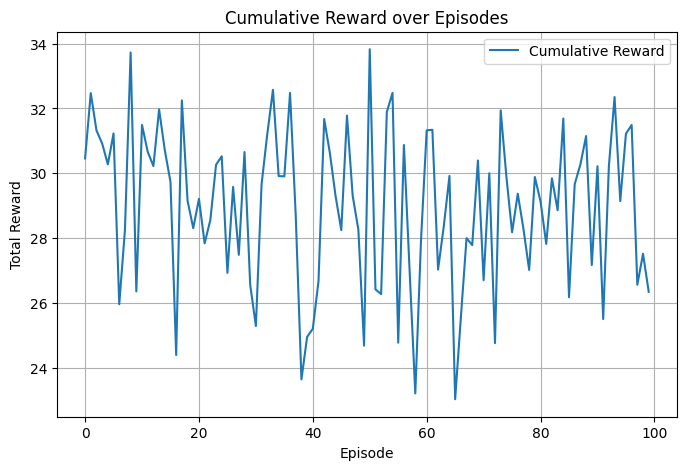

In [21]:
# Plot cumulative reward over episodes
plt.figure(figsize=(8, 5))
plt.plot(episode_rewards, label="Cumulative Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Cumulative Reward over Episodes")
plt.legend()
plt.grid()
plt.show()

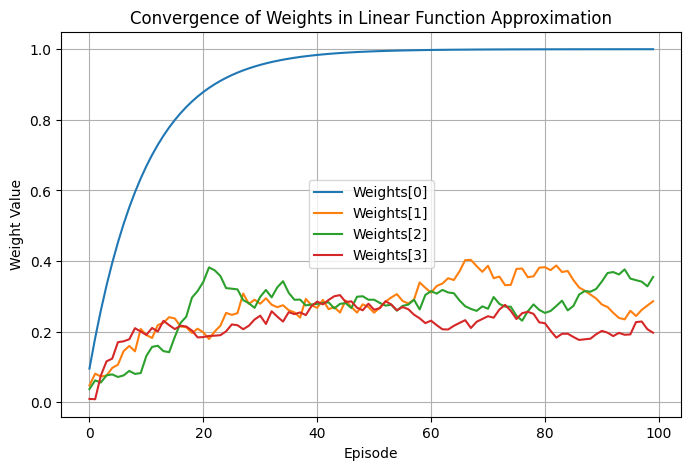

In [22]:
# Plot weights convergence
weights_history = np.array(weights_history)
plt.figure(figsize=(8, 5))
for i in range(weights_history.shape[1]):
    plt.plot(weights_history[:, i], label=f"Weights[{i}]")
plt.xlabel("Episode")
plt.ylabel("Weight Value")
plt.title("Convergence of Weights in Linear Function Approximation")
plt.legend()
plt.grid()
plt.show()

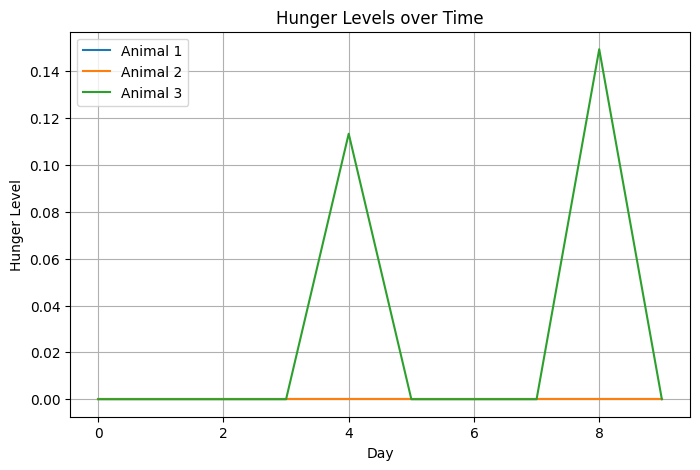

In [23]:
# Simulate policy and plot hunger levels and total utility over time
hunger_history, total_utility = simulate_policy_and_utility(weights)

# Plot hunger levels over time
plt.figure(figsize=(8, 5))
for i in range(hunger_history.shape[1]):
    plt.plot(hunger_history[:, i], label=f"Animal {i+1}")
plt.xlabel("Day")
plt.ylabel("Hunger Level")
plt.title("Hunger Levels over Time")
plt.legend()
plt.grid()
plt.show()

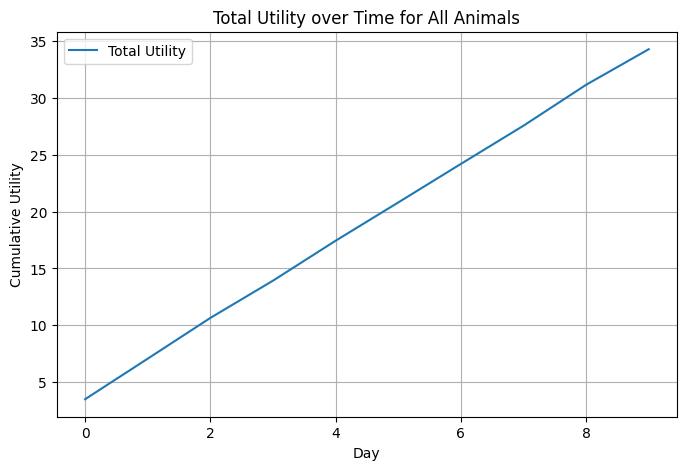

In [24]:
# Plot total utility over time
plt.figure(figsize=(8, 5))
plt.plot(range(T), total_utility, label="Total Utility")
plt.xlabel("Day")
plt.ylabel("Cumulative Utility")
plt.title("Total Utility over Time for All Animals")
plt.legend()
plt.grid()
plt.show()

### Part (E) Answer

### Part (E) Answer

1. The cumulative reward over 10 days for each of the 100 test episodes varied, but there was no trend. This is likely because the number of episodes is quite small.
2. **Convergence of Weights**: The weights[0] line looks different as it is the bias term, while all the others represent the hunger levels of the 3 respective animals.
3. **Hunger Levels Over Time**: There appears to be no particular pattern in this graph, but I did notice that higher hunger levels in the earlier days for animal 1 & 2 corresponded to lower hunger levels in the later dates and vice versa for animal 3.
4. **Total Utility Over Time**: This is approximately linear with a small and temporary decrease in gradient towards day 5. This makes sense as the amount of incremental utility should be relatively similar accross 10 days.
\end{enumerate}
